# CarpetX-based vs. Carpet-based code: structure and syntax
This notebook provides a commented version of a piece of source code from **AsterX**, the new GR(M)HD code built upon CarpetX, and highlights the main differences in structure and syntax between CarpetX-based and Carpet-based code. The code snippets in this notebook are mainly taken from:
- https://github.com/jaykalinani/AsterX/blob/main/AsterX/src/prim2con.cxx
- https://github.com/jaykalinani/AsterX/blob/main/AsterX/src/interp.hxx
- https://github.com/eschnett/CarpetX/blob/main/Loop/src/loop.hxx
- https://github.com/eschnett/CarpetX/blob/main/Loop/src/loop_device.hxx

## Primitives-to-conservatives conversion: basics
The GRMHD equations are usually cast in *flux-conservative* form before a numerical solution to them is attempted. The reason for that lies in the *Lax-Wendroff theorem*, which essentially states that if the numerical solution to an hyperbolic PDE cast in flux-conservative form converges to some function $f$ with increasing spatial grid resolution, then $f$ is a weak solution to the PDE at hand.


As an example, the conservation of the rest-mass density $\rho$ in flux-conservative form on a curved spacetime in the 3+1 formulation of GR reads

$$
\partial_t\left(\sqrt{\det\!\left(\gamma\right)}\,D\right) + \partial_j\left(\sqrt{\det\!\left(\gamma\right)}\,D\widetilde{v}^j\right) = 0\;,
$$

where

$$
\begin{align}
    D               &\equiv \rho W\\
    \widetilde{v}^j &\equiv \frac{u^j}{u^0} = \alpha v^j - \beta^j
\end{align}
$$

with $W$ the Lorentz factor, $u$ the fluid's 4-velocity, $v$ the fluid's 3-velocity ("Valencia velocity"), $\alpha$ the lapse and $\beta$ the shift vector. In this context, $\rho$ is called the **primitive** variable, while $D = \rho W$ is the **conservative** variable associated to it; $\rho$ is the quantity we are actually interested in, while $D$ is the one we are going to evolve in time within our numerical method.


For the sake of brevity, the the full set of GRMHD equations in conservation form and the definitions of all conservative variables are not reported here. We will just list the names of all the primitive and conservative variables used in AsterX:

| **Primitive variable** | **Description**                   |
| ---------------------- | --------------------------------  |
| `rho`                  | Rest-mass density                 |
| `press`                | Pressure                          |
| `eps`                  | Specific internal energy          |
| `vel`                  | Fluid's 3-velocity (3 components) |

| **Conservative variable** | **Description**                   |
| ------------------------- | --------------------------------- |
| `dens`                    | Conserved rest-mass density       |
| `tau`                     | Conserved internal energy         |
| `mom`                     | Conserved momentum (3 components) |


## Initialization
- `cctk.h`, `cctk_Arguments.h` and `cctk_Parameters.h` are the usual Cactus headers;
- `prim2con.hxx` defines some structs and a routine to perform the primitives-to-conservatives operation;
- `loop_device.hxx` is the CarpetX header file containing the infrastructure needed to perform loops on a GPU (use the `Loop` namespace!)

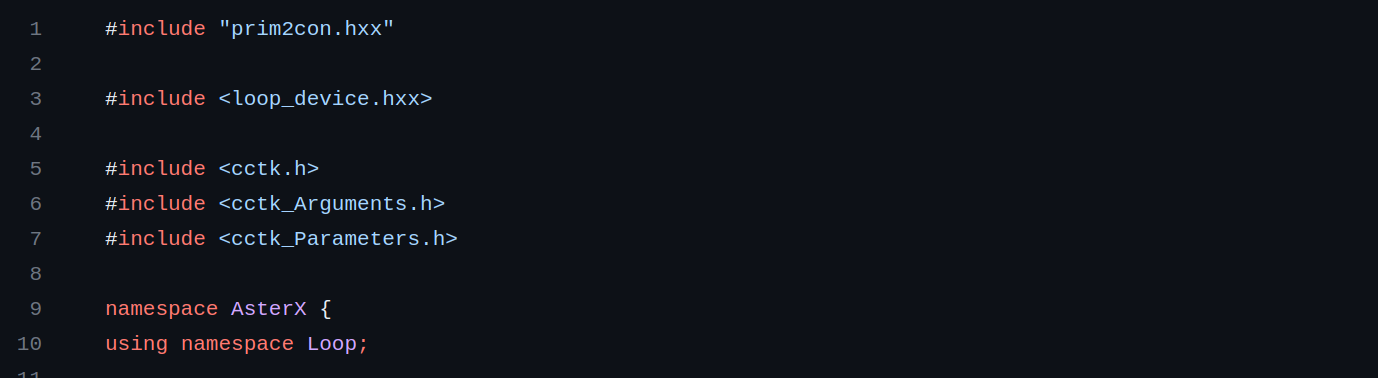

Now declare the scheduled function `AsterX_Prim2Con_Initial`, which performs the primitives-to-conservatives conversion in order to begin the time evolution:

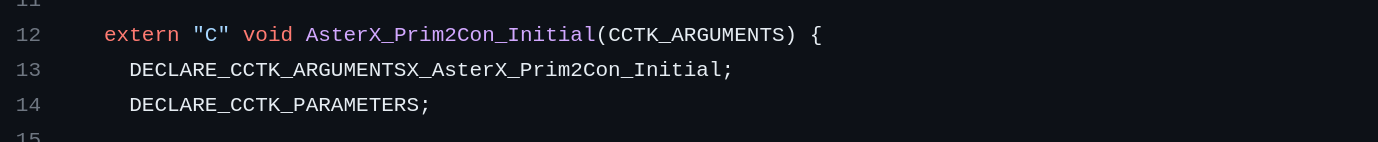

With Carpet, you would have
```
DECLARE_CCTK_ARGUMENTS_CHECKED(AsterX_Prim2Con_Initial);
```
**NOTE:**  don't forget the "X" in `ARGUMENTSX` in the CarpetX version of the macro!

## Looping on the GPU
A GPU cannot be used directly to run code; rather, we need a CPU (the _'host'_) to dump the workload to the GPU (the _'device'_) when desired. In CUDA, whose syntax is similar to C++, this is accomplished by qualifying a function with the keyword `__global__` to tell the compiler — **NVCC** — that the given function must be run on the GPU(s); this simple tweak turns a standard C++ function into a GPU _kernel_ (see https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html?#c-language-extensions for further info).

However, this is not the full story. In a nutshell, we need to:
1. manually allocate memory for all the variables we need on the host (via `malloc` or similar);
2. manually allocate memory for the copies of the above variables that should be passed to the device (via `cudaMalloc` or similar);
3. manually copy the variables from the host to the device (via `cudaMemcpy` or similar);
4. call the function to be executed on the device, i.e. _'launch the kernel'_. Notice that the number of blocks and the number of parallel threads per block the kernel should run on have to be specified manually;
5. manually transfer the processed data from the device back to the host;
6. manually free the allocated memory on the host;
7. manually free the allocated memory on the device.

See e.g. https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html?#device-memory for a simple example.

The above scheme rapidly gets clumsy and error-prone as the code gets bigger and more articulated; for this reason, by means of the AMReX infrastructure, CarpetX provides the user with useful, easy-to-use wrappers around the CUDA framework. By far one of the most helpful among such wrappers is the one used to launch a kernel performing **loops** on a GPU — a simple `for` loop won't work on the device.

The cell below shows how to set up a device loop over the interior of the whole physical domain of our simulation within CarpetX:

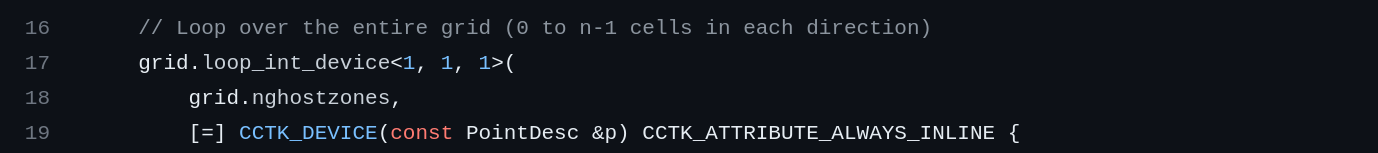

There are a few points worth noting in the lines above:
1. **VERY IMPORTANT:** on a regular CPU machine, the **same** piece of code performs (multithreaded) loops on a CPU. This means we don't need to write two different versions of the same code. However, if we want to use GPUs, we must choose to do so at **COMPILE TIME**;
2. `grid` is a `GridDescBaseDevice` object, which in turn is a struct defined in `loop_device.hxx`. `grid` is declared here by the macro `DECLARE_CCTK_ARGUMENTSX_AsterX_Prim2Con_Initial`;
3. the method `loop_int_device` from `GridDescBaseDevice` is used to loop over all interior grid points. Similar methods are defined inside `GridDescBaseDevice` to loop over different regions of the domain:
  - `loop_all_device`: loop over all points
  - `loop_bnd_device`: loop over all outer boundary points excluding ghost faces, but including ghost edges and corners of non-ghost faces
  - `loop_ghosts_device`: loop over all ghost points
  - `loop_there_device`: loop over a user-specified region of the domain
4. `<1, 1, 1>` means the loop is performed over _cell centers_; `<0, 0, 0>` would loop over cell vertices; `<1, 0, 0>`, `<0, 1, 0>` and`<0, 0, 1>` would loop over x/y/z cell edges; and `<1, 1, 0>`, `<1, 0, 1>` and `<0, 1, 1>` would loop over x/y/z cell faces;
5. `loop_int_device` takes two arguments: `grid.nghostzones` and the C++ lambda
```
[=] CCTK_DEVICE(const PointDesc &p) CCTK_ATTRIBUTE_ALWAYS_INLINE {<lambda body>}
```
Note that:
  - the lambda captures variables _by value_ (`[=]`): this is related to _copying_ variables from the host to the device. However, even when this code is run on a CPU, we need to capture variables by value and not by reference in order for multithreading to work properly (otherwise multiple threads would write on the same memory area at the same time);
  - the lambda is called _from the device_ to run on the device itself. From `loop.hxx`,
```
#define CCTK_DEVICE AMREX_GPU_DEVICE
```
where `AMREX_GPU_DEVICE` expands to `__device__`, which is in turn the CUDA keyword identifying functions which are supposed to be called from the device and run on it;
  - `const PointDesc &p` (see next paragraph) is a parameter passed to the lambda and representing a point on the grid;
  - `CCTK_ATTRIBUTE_ALWAYS_INLINE` tells the compiler to try and inline the body of the lambda.

### Point descriptor
CarpetX defines the `PointDesc` struct in `loop.hxx` as a very convenient way of accessing the value of any grid function at some given point:

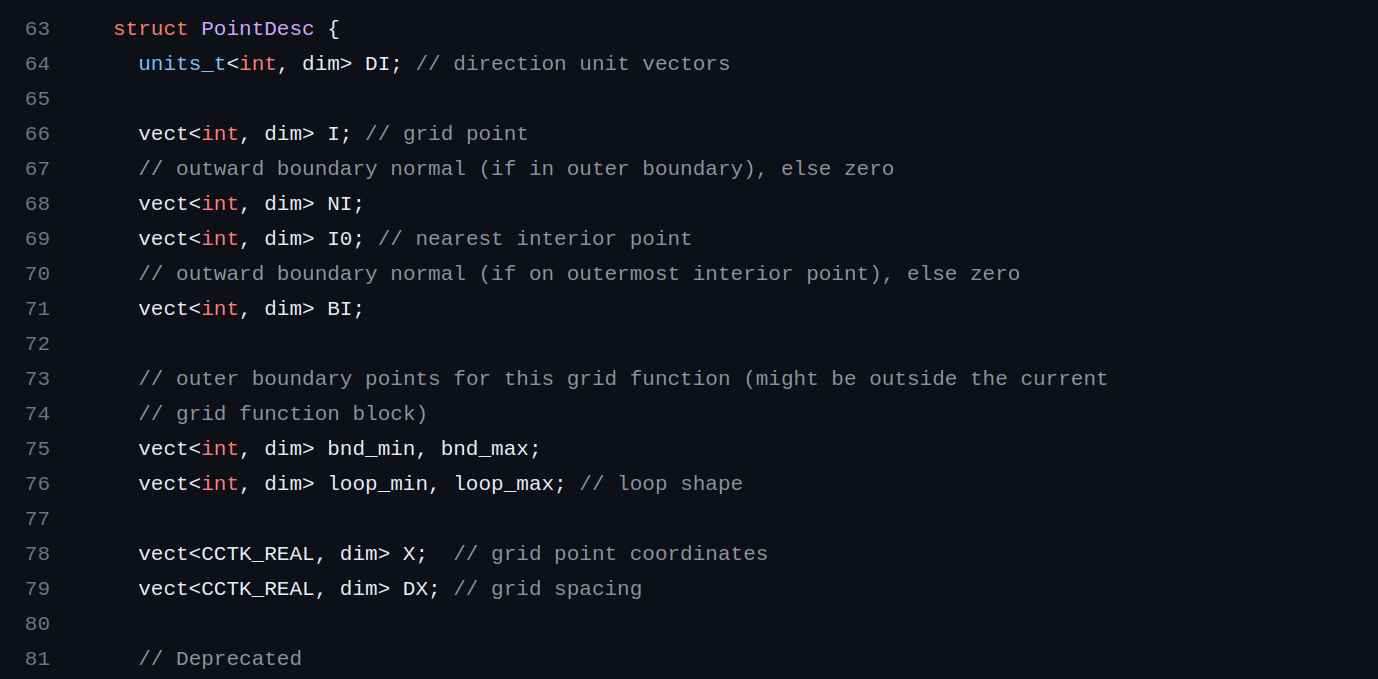

- `units_t` is also defined in `loop.hxx` and represents a unit vector along some direction;
- `vect` is an object representing a vector and is defined in https://github.com/eschnett/CarpetX/blob/main/Arith/src/vect.hxx .

### Body of the loop (i.e. body of the lambda)
Interpolate the vertex-centered metric to the center of the cell:

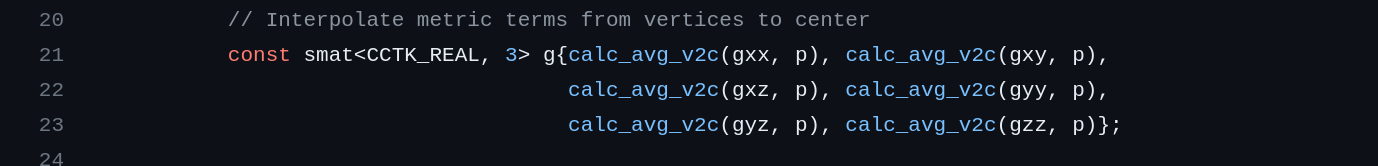

- `smat<CCTK_REAL, 3>` is a 3\*3 symmetric matrix
- `calc_avg_v2c` is defined by AsterX under `interp.hxx` and performs the desired interpolation of a grid function (e.g. `gxx`) onto point `p`

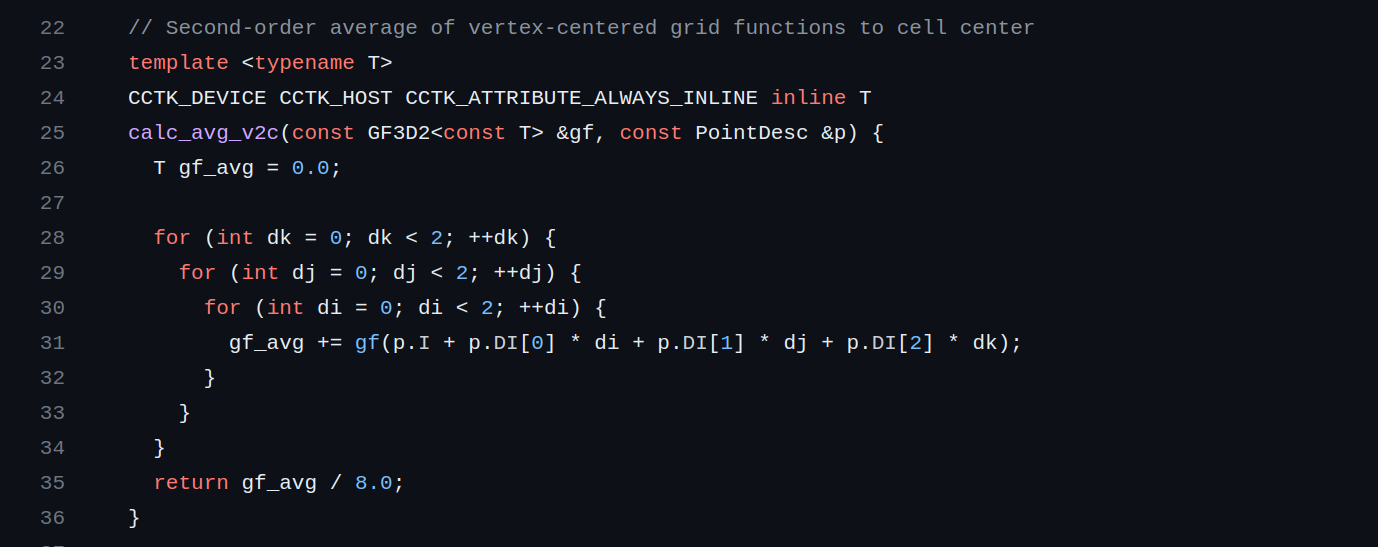

Finally, compute the conservative variables from the primitives:

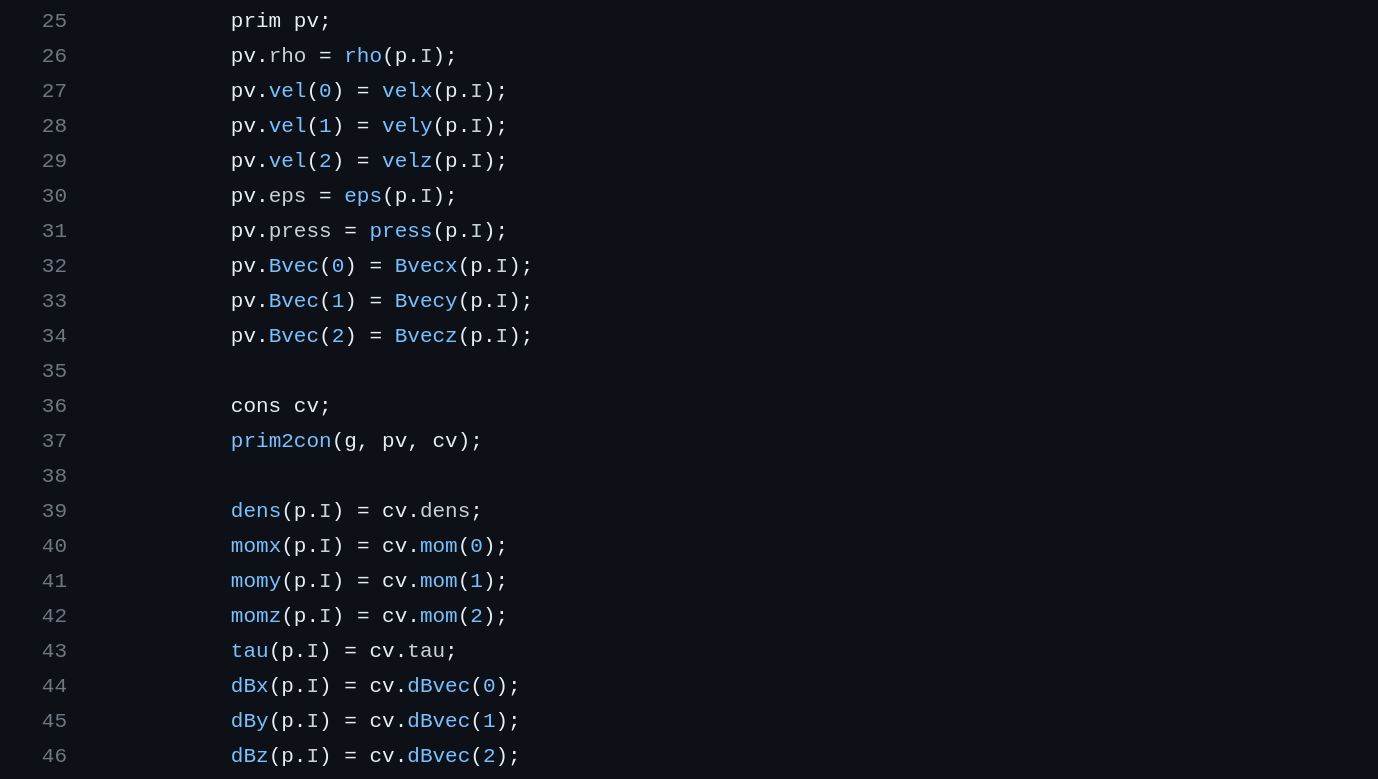

The structs `prim` and `cons` and the `prim2con`routine are defined in `prim2con.hxx`:
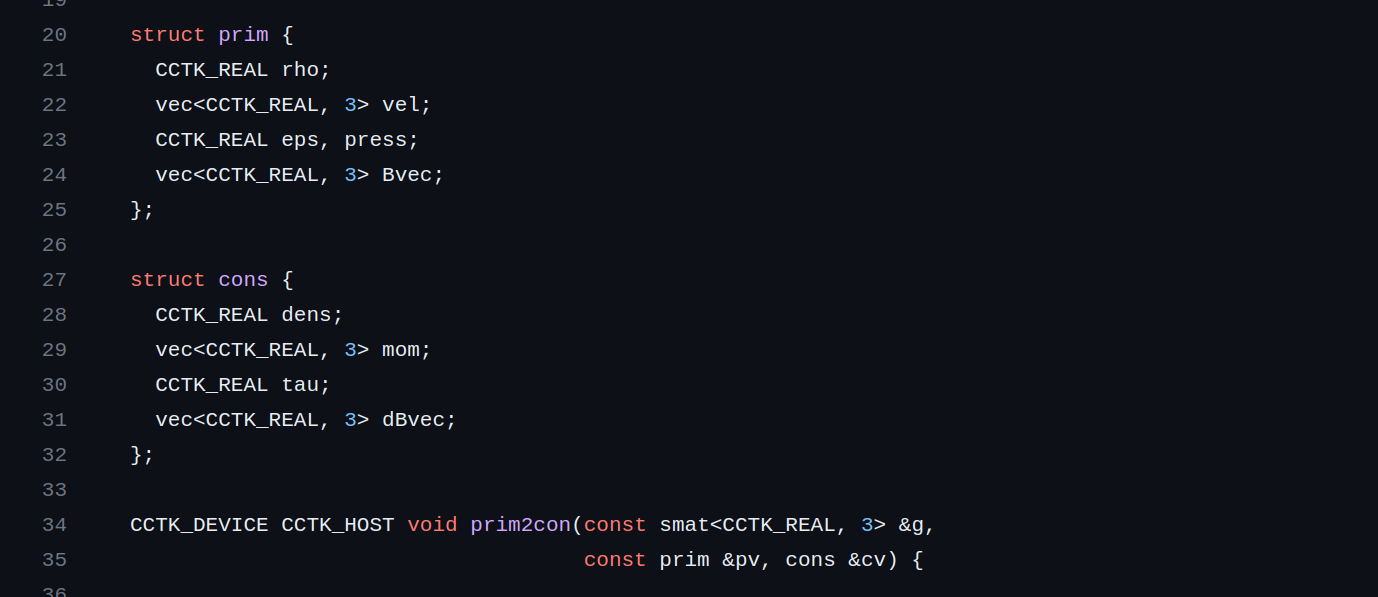

Comparison with Carpet
-----------------------------------
As we have just seen, the way of accessing grid function values has changed considerably with CarpetX compared to Carpet. In Carpet, the above loop would look something like this:
```
for (int k = 0; k < cctk_lsh[2]; ++k) {
  for (int j = 0; j < cctk_lsh[1]; ++j) {
    for (int i = 0; i < cctk_lsh[0]; ++i) {
      const auto ijk = CCTK_GFINDEX3D(cctkGH, i,   j,   k);

      const auto ipjk = CCTK_GFINDEX3D(cctkGH, i+1, j,   k);
      const auto ijpk = CCTK_GFINDEX3D(cctkGH, i,   j+1, k);
      const auto ijkp = CCTK_GFINDEX3D(cctkGH, i,   j,   k+1);

      const auto ipjpk = CCTK_GFINDEX3D(cctkGH, i+1, j+1, k);
      const auto ipjkp = CCTK_GFINDEX3D(cctkGH, i+1, j,   k+1);
      const auto ijpkp = CCTK_GFINDEX3D(cctkGH, i,   j+1, k+1);

      const auto ipjpkp = CCTK_GFINDEX3D(cctkGH, i+1, j+1, k+1);
 
      CCTK_REAL gxx_avg = gxx[ijk]     + gxx[ip1jk]   + gxx[ijp1k]   + gxx[ijkp1]
                        + gxx[ip1jp1k] + gxx[ip1jkp1] + gxx[ijp1kp1] + gxx[ip1jp1kp1];
      CCTK_REAL gxy_avg = gxy[ijk]     + gxy[ip1jk]   + gxy[ijp1k]   + gxy[ijkp1]
                        + gxy[ip1jp1k] + gxy[ip1jkp1] + gxy[ijp1kp1] + gxy[ip1jp1kp1];
      CCTK_REAL gxz_avg = gxz[ijk]     + gxz[ip1jk]   + gxz[ijp1k]   + gxz[ijkp1]
                        + gxz[ip1jp1k] + gxz[ip1jkp1] + gxz[ijp1kp1] + gxz[ip1jp1kp1];
      CCTK_REAL gyy_avg = gyy[ijk]     + gyy[ip1jk]   + gyy[ijp1k]   + gyy[ijkp1]
                        + gyy[ip1jp1k] + gyy[ip1jkp1] + gyy[ijp1kp1] + gyy[ip1jp1kp1];
      CCTK_REAL gyz_avg = gyz[ijk]     + gyz[ip1jk]   + gyz[ijp1k]   + gyz[ijkp1]
                        + gyz[ip1jp1k] + gyz[ip1jkp1] + gyz[ijp1kp1] + gyz[ip1jp1kp1];
      CCTK_REAL gzz_avg = gzz[ijk]     + gzz[ip1jk]   + gzz[ijp1k]   + gzz[ijkp1]
                        + gzz[ip1jp1k] + gzz[ip1jkp1] + gzz[ijp1kp1] + gzz[ip1jp1kp1];

      gxx_avg /= 8.;
      gxy_avg /= 8.;
      gxz_avg /= 8.;
      gyy_avg /= 8.;
      gyz_avg /= 8.;
      gzz_avg /= 8.;

      // Use gxx_avg, gxy_avg, gxz_avg, gyy_avg, gyz_avg, gzz_avg in some way
      do_something(gxx_avg, gxy_avg, gxz_avg, gyy_avg, gyz_avg, gzz_avg);
    }
  }
}
```

# Structure of CarpetX thorns
The structure of a CarpetX-based thorn is not very different from that of Carpet-based ones, except from a few important differences.

## `schedule.ccl`
In CarpetX, we **MUST** explicitly declare which grid functions are read and/or written by each scheduled routine via `READS` and `WRITES` statements and we must set the parameter `Cactus::presync_mode` in such a way as to take those keywords into consideration:

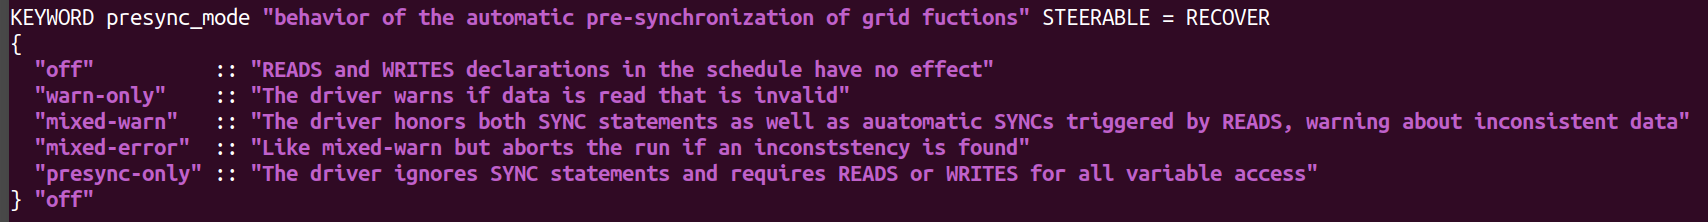

`READS` and `WRITES` statements are also accepted — but NOT mandated — by Carpet; it is however advisable to always include them in order to write clean and correct Carpet-based code.

As an example, the routine `AsterX_Prim2Con_Initial` above is scheduled in `AsterX/schedule.ccl` as:

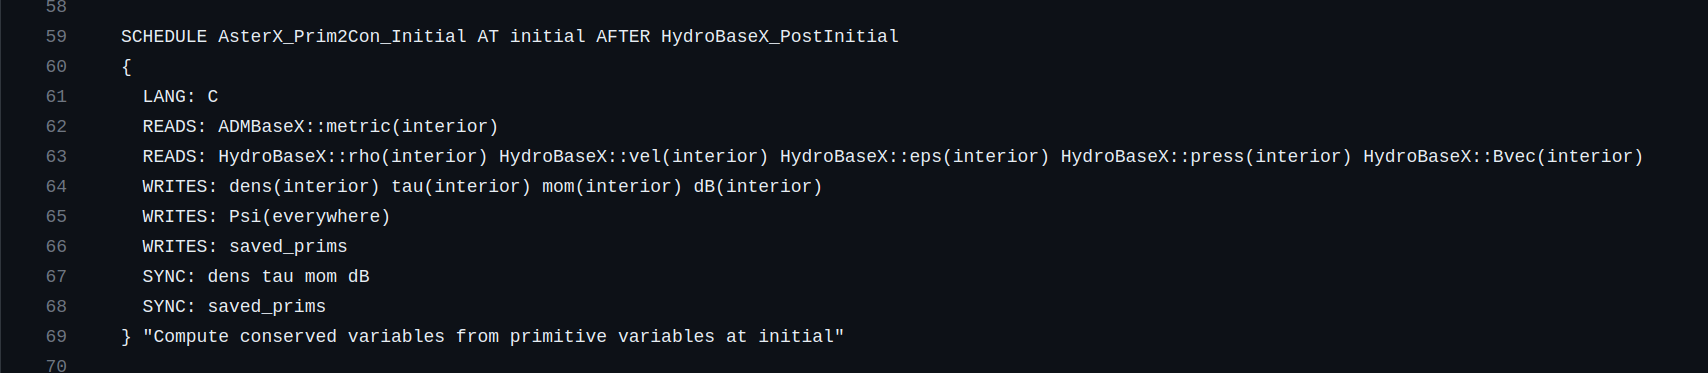

## `interface.ccl`
Declaring grid variables in CarpetX is slightly different than in Carpet. In particular, we have to specify the following:

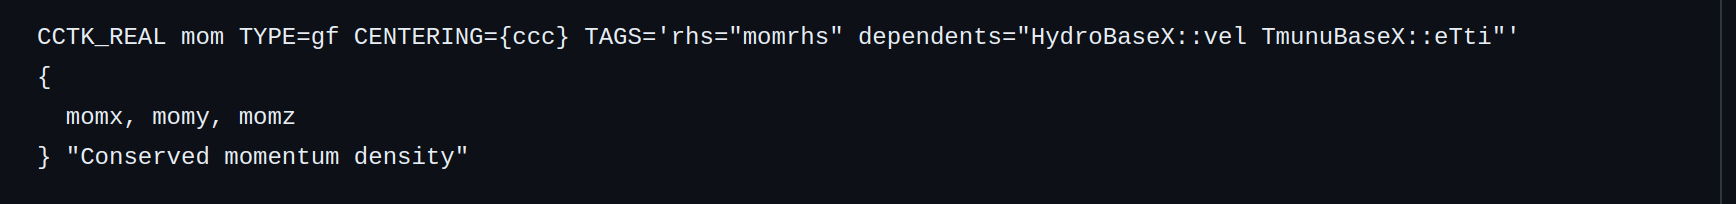

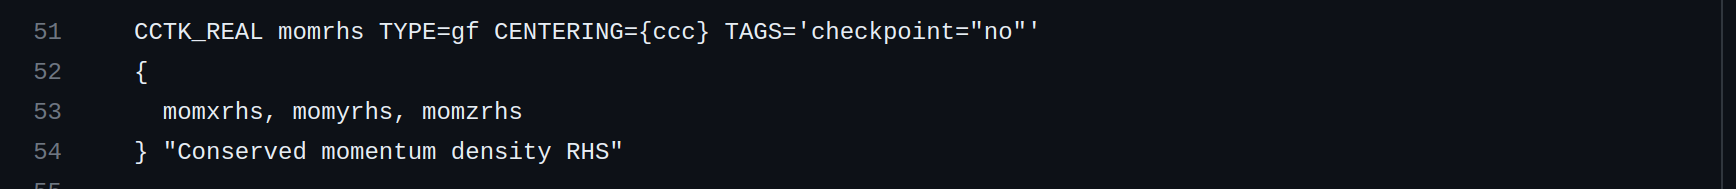

### Centering
AMReX natively supports various centerings for grid variables. The options are:
  - `ccc`: cell-centred
  - `vvv`: vertex-centered
  - `vcc`/`cvc`/`ccv`: edge-centered
  - `ccv`/`vcv`/`vcc`: face-centered

### RHS
Time-evolved variables (e.g. conservatives) must know what their corresponding right-hand-sides are in order for the method of lines thorn -- `ODESolvers` -- to perform the time evolution correctly. This replaces the Carpet-style `MOL` registering (i.e. no need to call `MoLRegisterEvolved` / `MoLRegisterConstrained`).

### Dependents
Whenever a grid variable declaring some dependent grid variables is updated, the latter are set to `NaN`.